## Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from DeepBeliefNetwork import DeepBeliefNetwork as DBN
from utils import StratifiedSampler 

## Small dataset class for MNIST

In [16]:
''' Dataset class '''
class MnistDataset(Dataset):
    
    def __init__(self, X, y):
    
        self.X  = torch.tensor(X).float()
        self.y = torch.tensor(y).int()
    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx,:]

## Training

Import dataset and make dataloaders

In [ ]:
path = './train.csv'

# Read images and labels
X  = pd.read_csv(path, usecols = range(1, 785)).values / 255 # Read pixel values
y  = pd.read_csv(path, usecols = [0]).values # Read label

# Train / validation set split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42)

# Dataloaders
train_set    = MnistDataset(X_train, y_train)
train_loader = DataLoader(dataset = train_set, 
                batch_size = 10, 
                shuffle    = False, 
                drop_last  = True,
                sampler  = StratifiedSampler(train_set.y, batch_size = 10)
                )

val_loader = DataLoader(dataset = MnistDataset(X_val, y_val), 
                batch_size = 10, 
                shuffle    = False,
                drop_last  = False
                )

Training:

In [3]:
device = 'cuda'

# Setup training
dbn = DBN(layer_nodes  = [784, 500, 500, 2000], # No. nodes on each layer [input, hidden, hidden, associative memory]
          no_labels    = 10,                    # No. of labels in the dataset (here 10 different digits)
          lr           = [5e-4, 5e-3],          # Learning rates for layerwise training and backfitting
          momentum     = [0, 0],                # Momentum for layerwise training and backfitting
          weight_decay = [0, 0],                # Weight decay rate for layerwise training and backfitting
          seed         = 123)                   # Seeds

# Send to device
dbn.to(device)

# Layer-wise greedy training
train_err_greedy, val_err_greedy   = dbn.layerwise_train(train_loader, val_loader, epochs = 10)

# Back-fitting (up-down) algorithm
train_err_backfit, val_err_backfit = dbn.backfit_train(train_loader, val_loader, epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Let's plot the results:

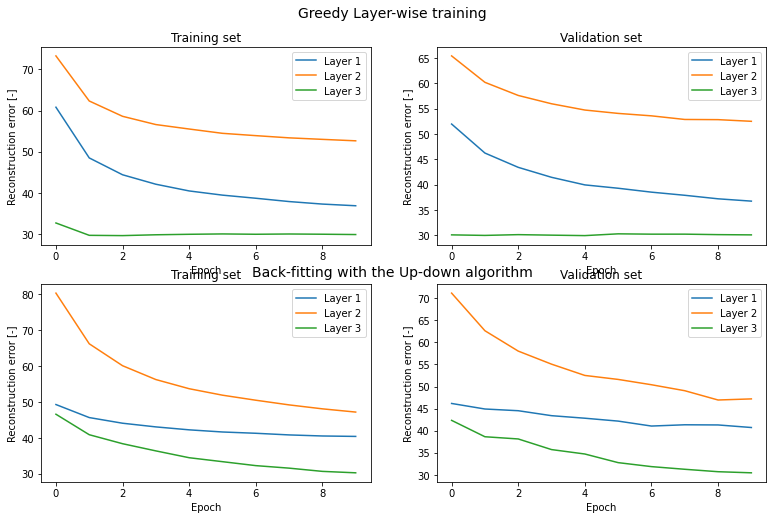

In [4]:
fig, ax = plt.subplots(figsize = (13, 8), nrows = 2, ncols = 2)

plt.figtext(0.5,0.95, "Greedy Layer-wise training", ha="center", va="top", fontsize=14)
plt.figtext(0.5,0.5, "Back-fitting with the Up-down algorithm", ha="center", va="top", fontsize=14)


ax[0,0].plot(train_err_greedy)
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Reconstruction error [-]')
ax[0,0].set_title('Training set')
ax[0,0].legend(['Layer 1', 'Layer 2', 'Layer 3'])

ax[0,1].plot(val_err_greedy)
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Reconstruction error [-]')
ax[0,1].set_title('Validation set')
ax[0,1].legend(['Layer 1', 'Layer 2', 'Layer 3'])

ax[1,0].plot(train_err_backfit)
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Reconstruction error [-]')
ax[1,0].set_title('Training set')
ax[1,0].legend(['Layer 1', 'Layer 2', 'Layer 3'])

ax[1,1].plot(val_err_backfit)
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_title('Validation set')
ax[1,1].set_ylabel('Reconstruction error [-]')
ax[1,1].legend(['Layer 1', 'Layer 2', 'Layer 3']);

## Inference

In [5]:
# Read images and labels
path = './test.csv'
X_test  = pd.read_csv(path).values / 255 # Read pixel values
X_test = torch.tensor(X_test, dtype = torch.float)

Predict and plot 4 random samples from the test set

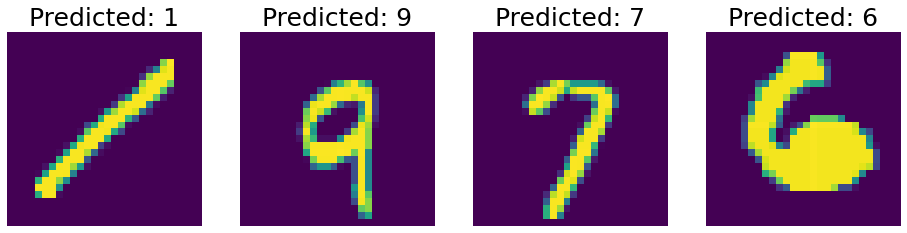

In [15]:
dbn.to(device)

fig, ax = plt.subplots(1, 4, figsize = (16, 5))

for i in range(4):
    
    idx = np.random.randint(0, X_test.shape[0])
    X = X_test[idx, :].reshape(1, -1).to(device)
    y = dbn.predict(X)

    ax[i].imshow(X_test[idx, :].reshape(28, -1))
    ax[i].set_title('Predicted: ' + str(y), fontsize = 25);
    ax[i].axis('off')
plt.show()